In [1]:
import pandas as pd
import numpy as np

In [2]:
from glob import glob
from pprint import pprint
import dill
import json

In [3]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
import bokeh.palettes as bpal
from bokeh.models import CategoricalColorMapper
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.models import Legend
from bokeh.io import export_png
output_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [4]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
def make_plotgrid(totalrange, ncols):
    """for feeding into bokeh griplot, returns array of rows/columns"""
    nrows = int(np.ceil(totalrange/ncols))
    feeder = iter(range(totalrange))
    plotgrid = [[]]*nrows
    for r in range(nrows):
        thisrow = []
        for c in range(ncols):
            try:
                thisrow.append(next(feeder))
            except:
                thisrow.append(None)
        plotgrid[r] = thisrow
    return plotgrid

In [6]:
def draw_gridplot(indf, columns='first', ncols=3, total_width=900, each_height=300, incolours = ['blue','red','yellow','green','purple','orange']):
    """Grid plots by month in bokeh
    Requires:
    > indf has datetime index
    > if columns are left unspecified (should be a list of col names), then just first column is plotted
    > only takes up to 6 columns, then runs out of colours to plot unless you put more into incolours"""
    if columns == 'first':
        columns = [indf.columns[0]]
    else:
        pass
    indf['Month'] = indf.index.month
    indf['mthname'] = indf.index.month_name()
    
    each_width = int(total_width/ncols)
    
    clrcols = [(col, clr) for col, clr in zip(columns, incolours)]
    dictmonth = {}
    
    for no,mth in enumerate(indf.mthname.unique()):
        dictmonth[no] = figure(plot_width=each_width, plot_height=each_height, title=mth, x_axis_type='datetime')
        for col, clr in clrcols:
            dictmonth[no].line(indf.index[indf.Month == no+1], indf[col][indf.Month == no+1], line_width=1, color = clr)
    
    plotgrid = make_plotgrid(len(indf.mthname.unique()), ncols=ncols)
    for row in range(len(plotgrid)):
        for p in range(len(plotgrid[row])):
            plotgrid[row][p] = dictmonth[plotgrid[row][p]]
    
    the_grid = gridplot(plotgrid)
    show(the_grid)
    return the_grid

In [7]:
feat_files = glob('../data/ready-for-model/*.csv')
feat_files

['../data/ready-for-model/2009-18_NEMtotaldemand.csv',
 '../data/ready-for-model/20190226_SAdf_features.csv',
 '../data/ready-for-model/20190226_TASdf_features.csv',
 '../data/ready-for-model/20190226_NSWdf_features.csv',
 '../data/ready-for-model/20190226_VICdf_features.csv',
 '../data/ready-for-model/20190226_QLDdf_features.csv']

In [8]:
ftarget = feat_files[0]
ftarget

'../data/ready-for-model/2009-18_NEMtotaldemand.csv'

In [9]:
dftarget = pd.read_csv(ftarget, index_col=0, parse_dates=[0])
dftarget.head(3)

,NSW1,QLD1,SA1,TAS1,VIC1,NEMtotal
SETTLEMENTDATE,,,,,,
2009-01-01 00:30:00,7535.00,5611.54,1310.89,909.71,4799.87,20167.01
2009-01-01 01:00:00,7229.24,5457.34,1272.69,896.63,4646.21,19502.11
2009-01-01 01:30:00,6857.62,5294.12,1178.87,897.52,4950.16,19178.29


In [10]:
target = dftarget[['NEMtotal']][dftarget.index.year == 2018]

In [11]:
target.isnull().sum()

NEMtotal    0
dtype: int64

In [12]:
target.head()

,NEMtotal
SETTLEMENTDATE,
2018-01-01 00:00:00,20038.93
2018-01-01 00:30:00,19465.44
2018-01-01 01:00:00,18991.62
2018-01-01 01:30:00,18418.38
2018-01-01 02:00:00,17934.71


<Figure size 432x288 with 0 Axes>

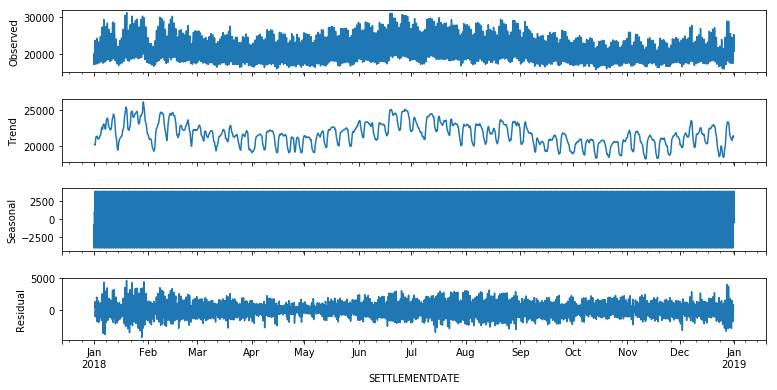

In [13]:
decomposition = seasonal_decompose(target.NEMtotal, freq = 48)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

In [14]:
dfdecomp = pd.DataFrame(data=decomposition.seasonal.values, index=decomposition.seasonal.index, columns=['Seasonal'])
dfdecomp['Trend'] = decomposition.trend.values
dfdecomp['Resid'] = decomposition.resid.values
dfdecomp.dropna(inplace=True)
dfdecomp.head()

,Seasonal,Trend,Resid
SETTLEMENTDATE,,,
2018-01-01 12:00:00,-241.698528,20169.343646,419.344882
2018-01-01 12:30:00,-259.187413,20162.878021,446.589392
2018-01-01 13:00:00,-229.585823,20155.332292,678.573531
2018-01-01 13:30:00,-122.619500,20147.489063,786.130438
2018-01-01 14:00:00,29.502806,20140.957708,893.029486


In [15]:
draw_gridplot(dfdecomp, columns=['Seasonal', 'Trend', 'Resid'], incolours=['blue','red','green'])

Column(id='1921', ...)

<Figure size 432x288 with 0 Axes>

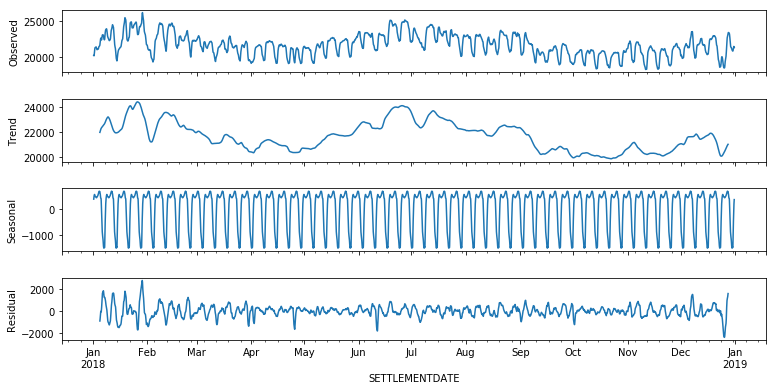

In [16]:
weekly = seasonal_decompose(dfdecomp.Trend, freq = 336)
fig1 = plt.figure()  
fig1 = weekly.plot()  
fig1.set_size_inches(12, 6)

In [19]:
dfdecomp.head()

,Seasonal,Trend,Resid,Month,mthname
SETTLEMENTDATE,,,,,
2018-01-01 12:00:00,-241.698528,20169.343646,419.344882,1,January
2018-01-01 12:30:00,-259.187413,20162.878021,446.589392,1,January
2018-01-01 13:00:00,-229.585823,20155.332292,678.573531,1,January
2018-01-01 13:30:00,-122.619500,20147.489063,786.130438,1,January
2018-01-01 14:00:00,29.502806,20140.957708,893.029486,1,January


In [21]:
dfdecomp['wkSeason'] = weekly.seasonal.values
dfdecomp['wkTrend'] = weekly.trend.values
dfdecomp['wkResid'] = weekly.resid.values
dfdecomp.head()

,Seasonal,Trend,Resid,Month,mthname,wkSeason,wkTrend,wkResid
SETTLEMENTDATE,,,,,,,,
2018-01-01 12:00:00,-241.698528,20169.343646,419.344882,1,January,391.879645,NaN,NaN
2018-01-01 12:30:00,-259.187413,20162.878021,446.589392,1,January,408.991245,NaN,NaN
2018-01-01 13:00:00,-229.585823,20155.332292,678.573531,1,January,424.939477,NaN,NaN
2018-01-01 13:30:00,-122.619500,20147.489063,786.130438,1,January,439.826475,NaN,NaN
2018-01-01 14:00:00,29.502806,20140.957708,893.029486,1,January,453.544689,NaN,NaN


In [23]:
dfdecomp = dfdecomp[['Month', 'mthname', 'Seasonal', 'Trend', 'Resid', 'wkSeason' , 'wkTrend' , 'wkResid']]
dfdecomp.head(2)

,Month,mthname,Seasonal,Trend,Resid,wkSeason,wkTrend,wkResid
SETTLEMENTDATE,,,,,,,,
2018-01-01 12:00:00,1,January,-241.698528,20169.343646,419.344882,391.879645,NaN,NaN
2018-01-01 12:30:00,1,January,-259.187413,20162.878021,446.589392,408.991245,NaN,NaN


In [24]:
dfdecomp.rename(columns={'Seasonal':'dlySeason', 'Trend':'dlyTrend', 'Resid' : 'dlyResid'}, inplace=True)
dfdecomp.head(2)

,Month,mthname,dlySeason,dlyTrend,dlyResid,wkSeason,wkTrend,wkResid
SETTLEMENTDATE,,,,,,,,
2018-01-01 12:00:00,1,January,-241.698528,20169.343646,419.344882,391.879645,NaN,NaN
2018-01-01 12:30:00,1,January,-259.187413,20162.878021,446.589392,408.991245,NaN,NaN


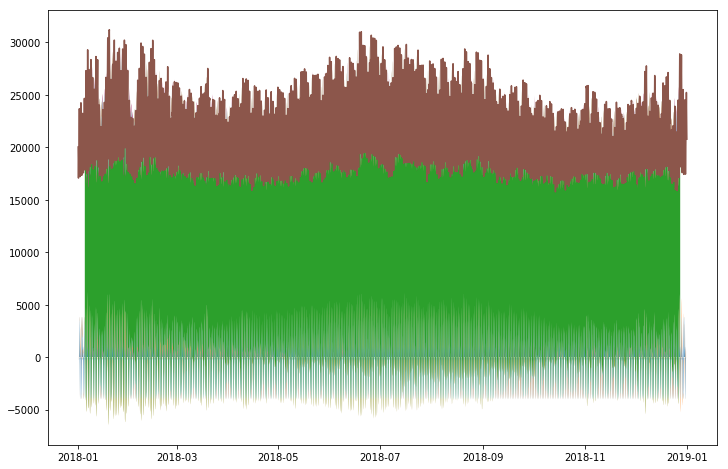

In [35]:
fig2, ax2 = plt.subplots(figsize = (12,8))

ax2.stackplot(dfdecomp.index, dfdecomp.dlySeason, dfdecomp.dlyResid, dfdecomp.wkTrend, dfdecomp.wkSeason, dfdecomp.wkResid)
ax2.plot(target.index, target.NEMtotal)

plt.show()

In [42]:
components = dfdecomp.columns[2:].tolist()
components.remove('dlyTrend')
components

['dlySeason', 'dlyResid', 'wkSeason', 'wkTrend', 'wkResid']

In [54]:
dfdecomp['Total'] = dfdecomp[components].sum(axis=1)
dfdecomp.head()

,Month,mthname,dlySeason,dlyTrend,dlyResid,wkSeason,wkTrend,wkResid,Total,NEMtotal
SETTLEMENTDATE,,,,,,,,,,
2018-01-01 12:00:00,1,January,-241.698528,20169.343646,419.344882,391.879645,NaN,NaN,569.525999,20346.99
2018-01-01 12:30:00,1,January,-259.187413,20162.878021,446.589392,408.991245,NaN,NaN,596.393224,20350.28
2018-01-01 13:00:00,1,January,-229.585823,20155.332292,678.573531,424.939477,NaN,NaN,873.927186,20604.32
2018-01-01 13:30:00,1,January,-122.619500,20147.489063,786.130438,439.826475,NaN,NaN,1103.337413,20811.00
2018-01-01 14:00:00,1,January,29.502806,20140.957708,893.029486,453.544689,NaN,NaN,1376.076980,21063.49


In [50]:
dfdecomp = pd.merge(dfdecomp, target[['NEMtotal']], how='left', left_index=True, right_index=True)

In [55]:
dfdecomp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17472 entries, 2018-01-01 12:00:00 to 2018-12-31 11:30:00
Data columns (total 10 columns):
Month        17472 non-null int64
mthname      17472 non-null object
dlySeason    17472 non-null float64
dlyTrend     17472 non-null float64
dlyResid     17472 non-null float64
wkSeason     17472 non-null float64
wkTrend      17136 non-null float64
wkResid      17136 non-null float64
Total        17472 non-null float64
NEMtotal     17472 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.5+ MB


In [58]:
ndfdecomp = dfdecomp.dropna()

In [63]:
ndfdecomp[abs(ndfdecomp.Total - ndfdecomp.NEMtotal) > 0.01]

,Month,mthname,dlySeason,dlyTrend,dlyResid,wkSeason,wkTrend,wkResid,Total,NEMtotal
SETTLEMENTDATE,,,,,,,,,,
